[![icons8-linkedin.gif](attachment:c9494563-7284-4c71-9fe4-40d31b4558ff.gif 'Author : Suryakant Kumar')](https://www.linkedin.com/in/suryakantkumar/)[![icons8-github.gif](attachment:ecd1af6f-8660-4379-b68f-bad3ed6d67c8.gif 'Author : Suryakant Kumar')](https://github.com/SuryakantKumar)
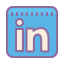
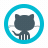

# <span style="color:skyblue">**PythonOperator - Execute Python Callable**</span>

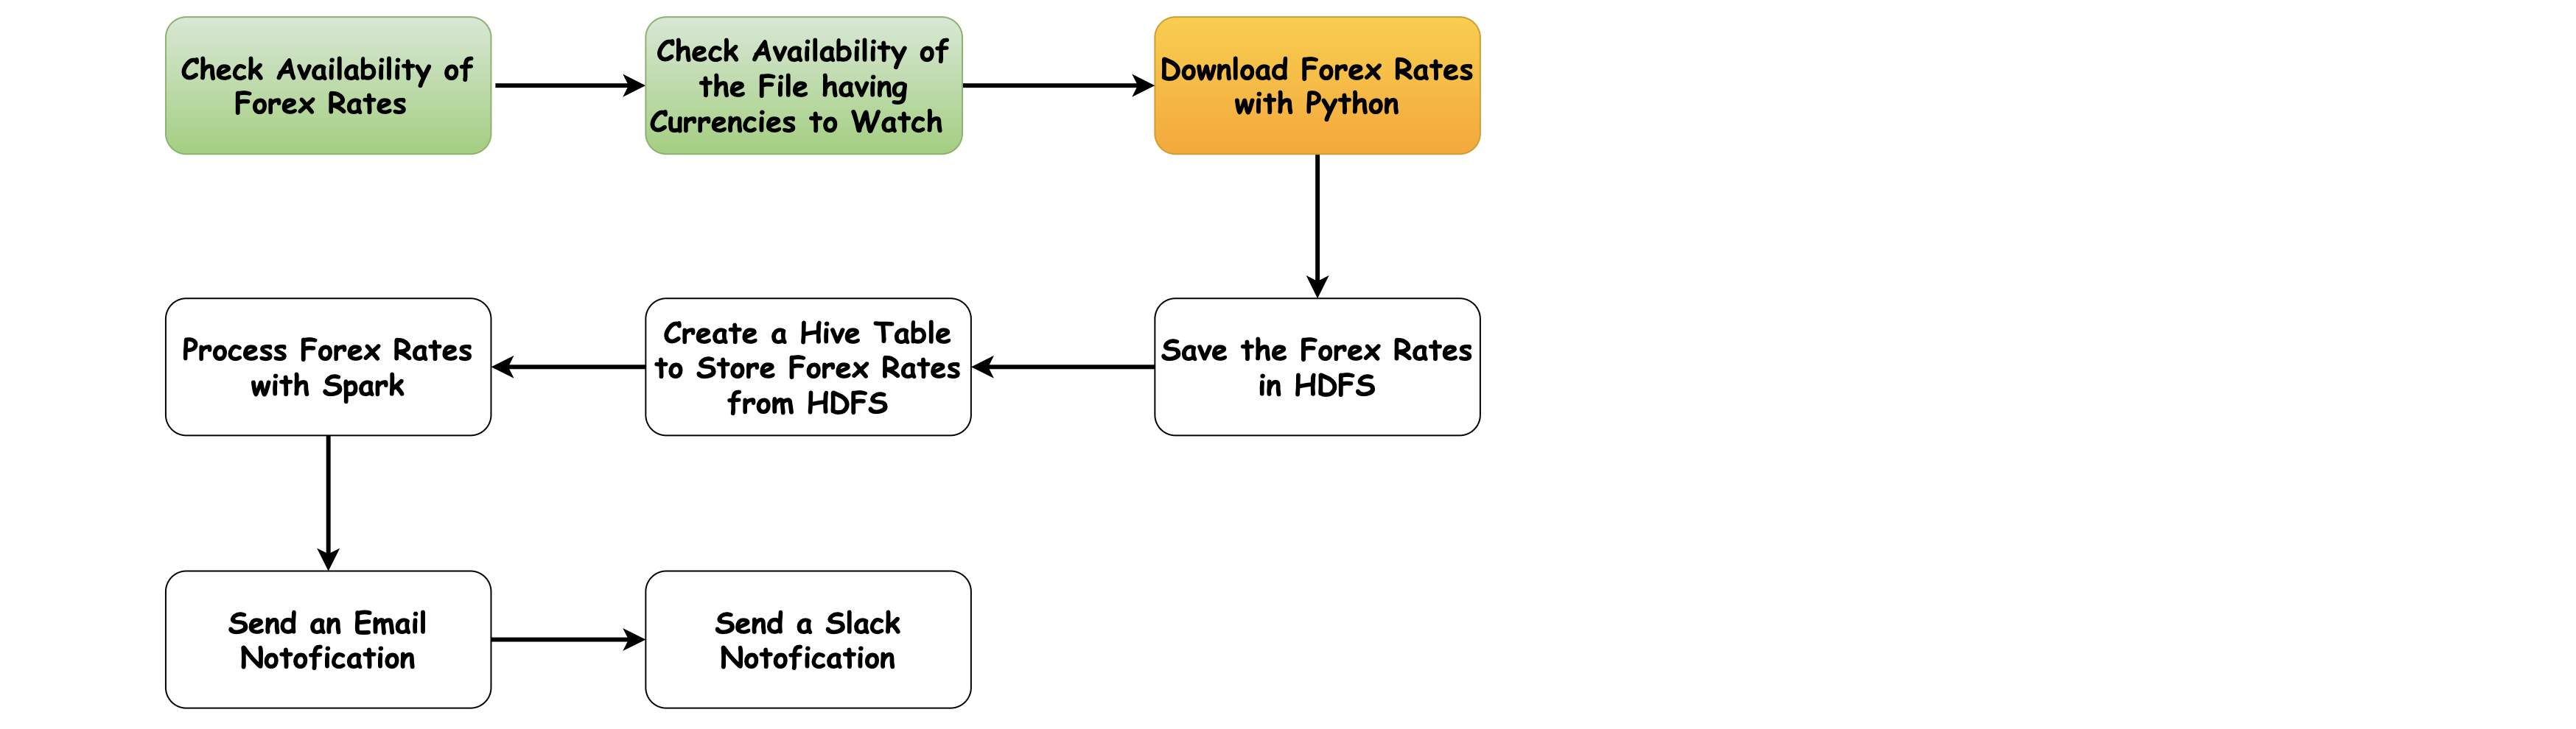

Third task in our data pipeline is to download forex rates from the file hosted on Github Gist, related to the currencies we want to watch.

In this case, We're going to use `PythonOperator` that executes any python callables, just like a `function`.

### <span style="color:orange">Import PythonOperator</span>

Here, We need to import `PythonOperator` in our DAG file `forex_data_pipeline.py`

```python
from airflow.operators.python import PythonOperator
```

### <span style="color:orange">Python Function To Download Forex Rates</span>

First, We will import some libraries like `csv` and `json` to read and write the data from respective formatted files, and `requests` to send the HTTP get request.

```python
import csv
import json
import requests
```

Then, We will implement a function which will download forex rates according to the currencies we want to watch.

```python
def download_rates():
    BASE_URL = "https://gist.github.com/SuryakantKumar/b38be3c4e51846151929d023b1e4c758/raw/"
    ENDPOINTS = {"USD": "api_forex_exchange_usd.json", "EUR": "api_forex_exchange_eur.json"}
    
    with open("/opt/airflow/dags/files/forex_currencies.csv") as forex_currencies:
        reader = csv.DictReader(forex_currencies, delimiter = ";")
        
        for idx, row in enumerate(reader):
            base = row["base"]
            with_pairs = row["with_pairs"].split(" ")
            indata = requests.get(f"{BASE_URL}{ENDPOINTS[base]}").json()
            outdata = {"base": base, "rates": {}, "last_update": indata["date"]}
            
            for pair in with_pairs:
                outdata["rates"][pair] = indata["rates"][pair]
            
            with open("/opt/airflow/dags/files/forex_rates.json", "a") as outfile:
                json.dump(outdata, outfile)
                outfile.write("\n")
```

This Python function performs the following tasks:

* It opens the CSV file named `forex_currencies.csv` stored at `/opt/airflow/dags/files/` location in file system of docker container running airflow, which contains information about currencies and their pairs.

* For each row in the CSV file, the function extracts the `base` currency and its associated currency `pairs`.

* Using the provided base currency, the function sends `HTTP GET requests` to the URL of the file hosted on github gist, to retrieve currency exchange rate data in JSON format.

* Now, It constructs a dictionary containing the `base currency`, `exchange rates`, and the `last update time` obtained from the JSON response.

* Then, It appends the constructed dictionary to a JSON file named `forex_rates.json`, which contains rates for all the currency pairs, for the base currencies USD and EUR.

### <span style="color:orange">Create Python Task</span>

We need to add a new variable to represent the task, that is `download_forex_rates` here.

```python
download_forex_rates = PythonOperator(task_id = "download_forex_rates",
                                      python_callable = download_rates)
```

Here, We have created a task with the necessary parameters :

* **`task_id`** : An unique identifier commonly used for all the tasks / operators. Each operator must have a unique task ID within the DAG.

* **`python_callable`** : Python `function` / script that we want to execute.

We can specify more parameters based on the need, these are :

* **op_kwargs** : A dictionary of keyword arguments that will get unpacked in our function

* **op_args** : A list of positional arguments that will get unpacked when calling our callable

### <span style="color:orange">Test / Run Airflow Task</span>

Open a terminal in our code editor and run `docker ps` to list all running Docker containers.

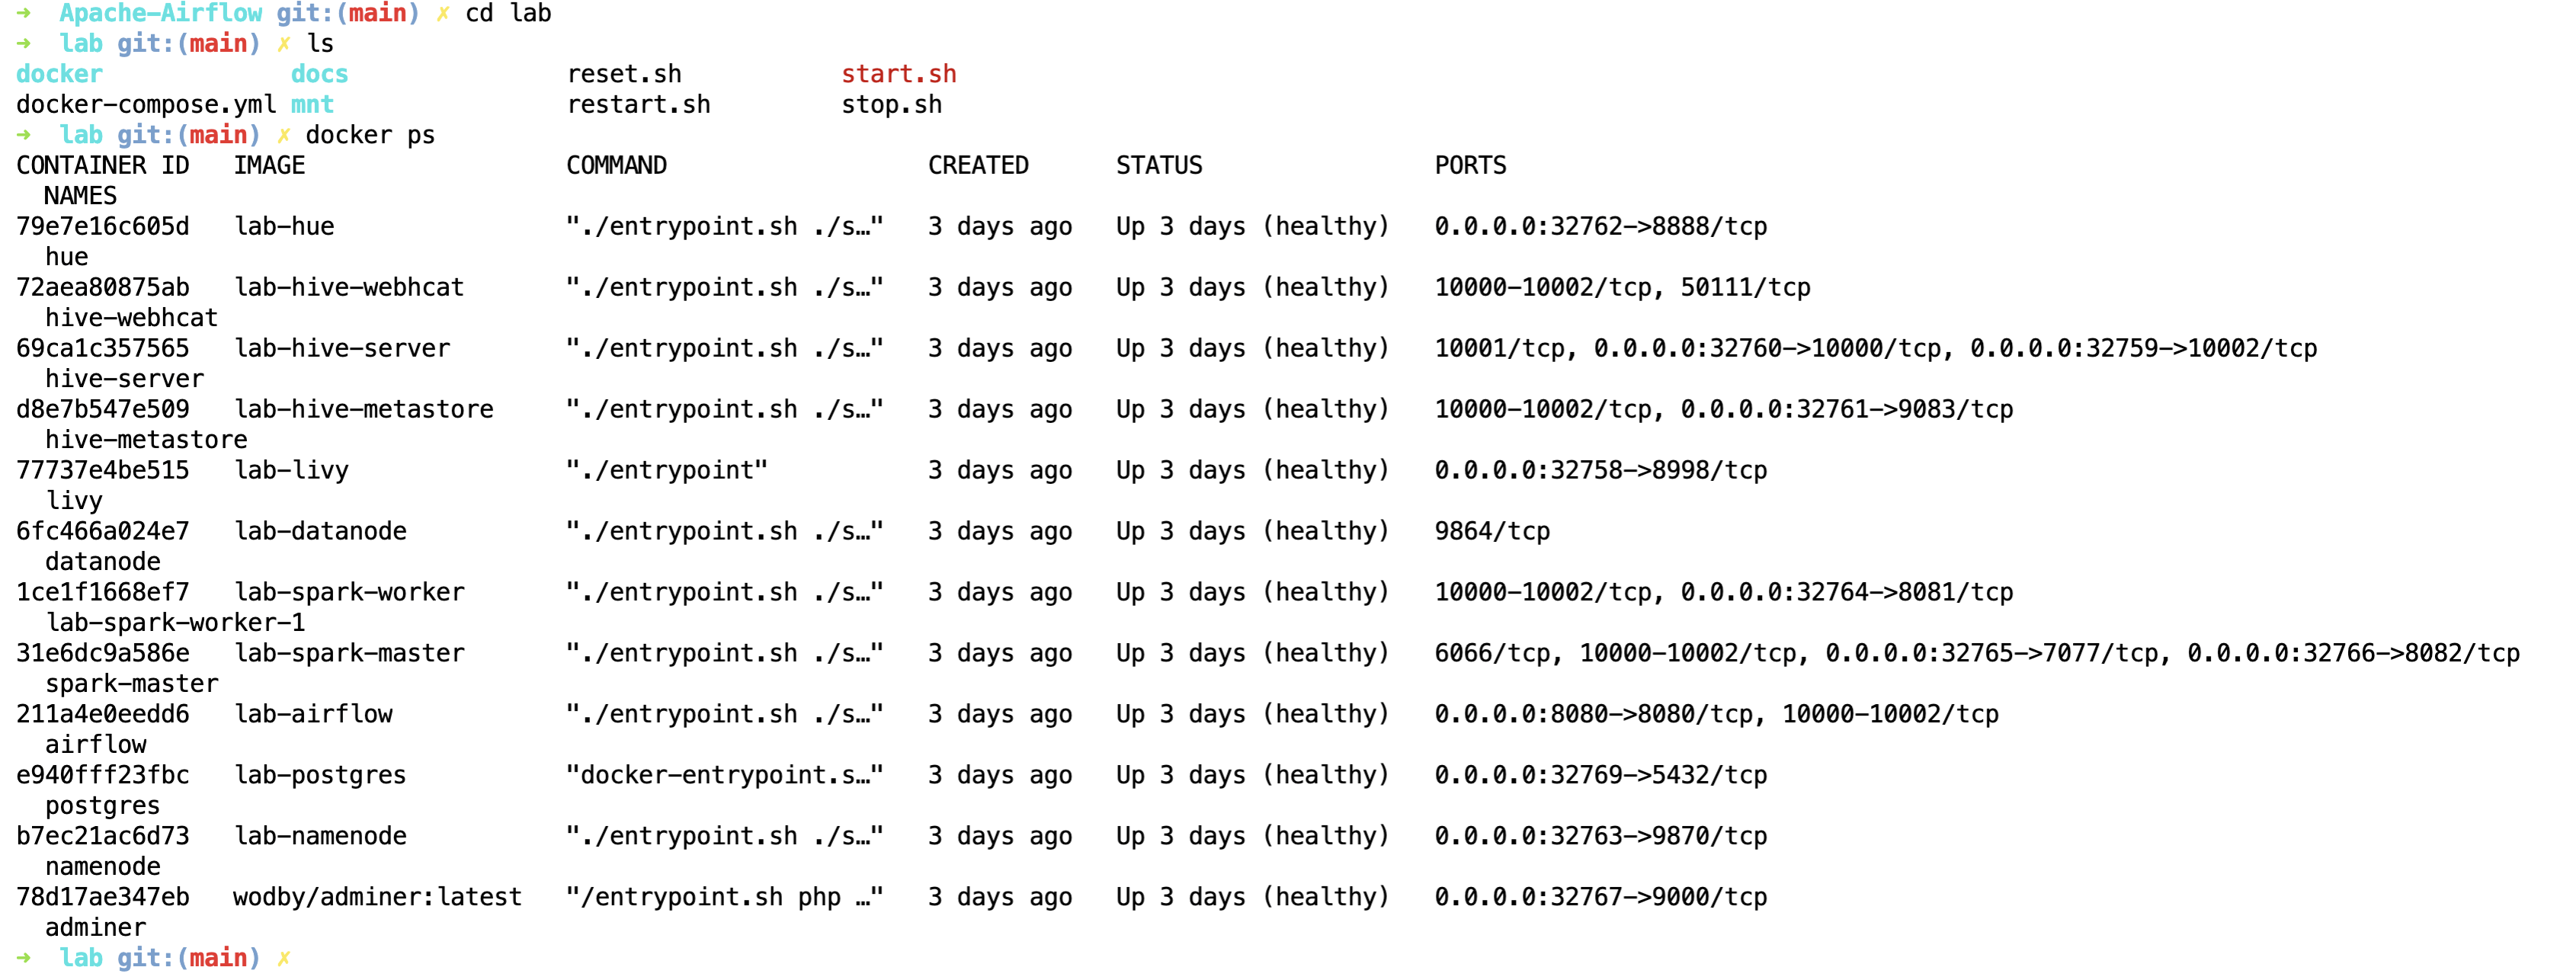

Next, Identify and Copy the container ID of Airflow, that is `211a4e0eedd6`

Now, Run `docker exec -it <container_id> /bin/bash` command to start an interactive bash session within the Airflow container. This command allows direct access to the file system within the container.

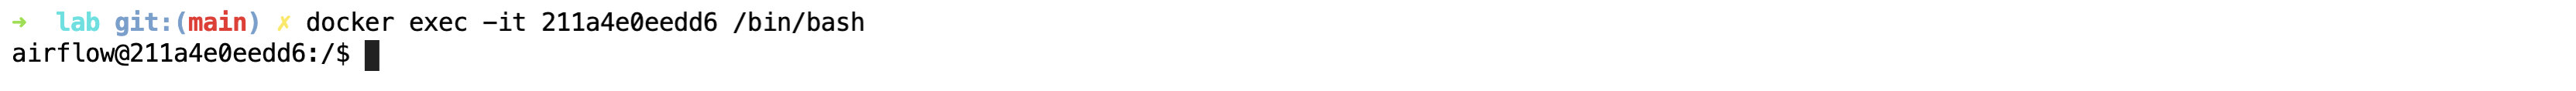

Currently, We are at the `root`.

Now, Run the command `airflow tasks test <DAG_ID> <TASK_ID> <EXECUTION_DATE_IN_THE_PAST>` inside the Airflow container's shell to test the task without storing any states in the metadata of airflow.

```shell
airflow tasks test forex_data_pipeline download_forex_rates 2024-02-01
```

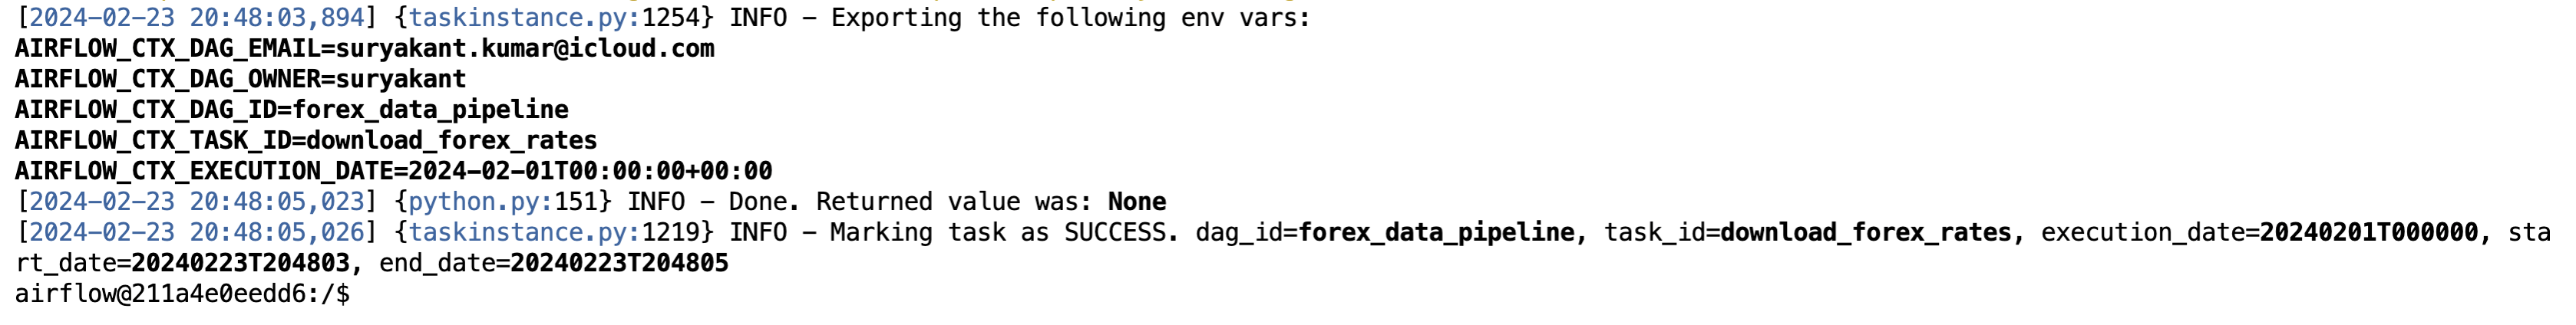

It is showing, the task execution was successful.

Now, A new file named `forex_rates.json` has been generated in `opt/airflow/dags/files` directory which currencies rates of all the pairs for base currencies.

```json
{"base": "EUR", "rates": {"USD": 1.13, "NZD": 1.41, "JPY": 101.89, "GBP": 0.36, "CAD": 1.21}, "last_update": "2024-02-24"}
{"base": "USD", "rates": {"EUR": 0.9, "NZD": 1.52, "JPY": 108.56, "GBP": 0.76, "CAD": 1.35}, "last_update": "2024-02-24"}
```